In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
from scipy import stats
from sklearn import linear_model

%matplotlib inline

# 1

In [5]:
fc = 1e9 # Hz
Lr = 2 # dB
F = 2 # dB
kT0 = -174 # dBm/Hz
B = 10 * np.log10(1e6) # dBHz
print("B: {:.0f} dBHz".format(B))
SNR = 10 # dB
Sr = SNR + kT0 + B + F + Lr
print("Sr: {:.0f} dBm".format(Sr))

B: 60 dBHz
Sr: -100 dBm


In [6]:
Pt = 10*np.log10(1000) # dBm
print("Pt: {:.0f} dBm".format(Pt))
# Pt - Lp = Sr
# Pt + 50 - 10log(fc) - 30log(d) = Sr
# 30log(d) = Pt - Sr + 50 - 10log(fc)
# log(d) = (Pt - Sr + 50 - 10log(fc)) / 30
d = 10**((Pt - Sr + 50 - 10*np.log10(fc))/30)
print("Range: {:.0f} m".format(d))

Pt: 30 dBm
Range: 1000 m


In [7]:
d = 2000 # m
Lp = -50 + 10*np.log10(fc) - 30*np.log10(d)
print("Lp: {:.0f} dB".format(Lp))
Pt = -Sr + Lp
print("Pt: {:.0f} dBm".format(Pt))


Lp: -59 dB
Pt: 41 dBm


# 2

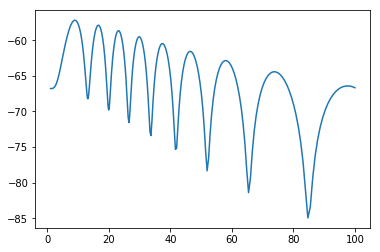

In [8]:
def path_loss_db(d, fc, ht, hr, epsilon=15, polarization='horizontal'):
    """
    two_ray_loss - path loss for a two ray channel
    
    Usage:
      path_loss = two_ray_loss(d, fc, hb, hm, epsilon, polarization)
    
    Inputs:
      d - distance (meters) between (base of) transmiter and receiver
      fc - carrier frequency
      ht - transmitter antenna height (meters)
      hr - receiver antenna height (meters)
      epsilon - relative dielectric constant of grond (default: 15)
      polarization - either 'vertical' or 'horizontal' (default: 'horizontal')
    
    Output:
      path_loss in dB
    """
    assert polarization in ('horizontal', 'vertical'), "Polarization must be either 'horizontal' or 'vertical'"

    c = 299792458.0 # m/s, speed of light
    wavelength = c/fc # m
    # set up geometry
    tx_loc = np.array([0, ht], dtype=np.float) # tx antenna position
    rx_loc = np.array([d, hr], dtype=np.float) # rx antenna position
    ref_rx_loc = np.array([d, -hr], dtype=np.float) # image antenna position
    # compute path lengths
    l_los = np.linalg.norm(tx_loc - rx_loc)
    l_ref = np.linalg.norm(tx_loc - ref_rx_loc)
    # angle of reflection
    # the slope of the line from tx to reflected rx equal the tangent of the
    # angle between that ray and teh ground plane
    slope = (ht + hr) / d
    ref_angle = np.arctan(slope)
    # reflection cefficient
    if polarization == 'horizontal':
        Z = np.sqrt(epsilon - np.cos(ref_angle)**2)
    else:
        Z = 1/epsilon*np.sqrt(epsilon - np.cos(ref_angle)**2)
    R = (np.sin(ref_angle) - Z)/(np.sin(ref_angle) + Z)
    # path loss
    # phase difference due to delay difference
    d_phi = 2*np.pi/wavelength*(l_ref - l_los);
    # inverse of path loss on linear scale 
    path_gain_lin = (wavelength/(4*np.pi))**2 * np.abs(1/l_los + R*np.exp(-1j*d_phi)/l_ref)**2;
    # turn into path loss in db
    return -10*np.log10(path_gain_lin);


fc = 900e6
ht = 30
hr = 2
n_pts = 500
d_array = np.logspace(0, 2, n_pts)
loss_db = np.array([path_loss_db(d, fc, ht, hr) for d in d_array])

plt.plot(d_array, -loss_db)
    
    

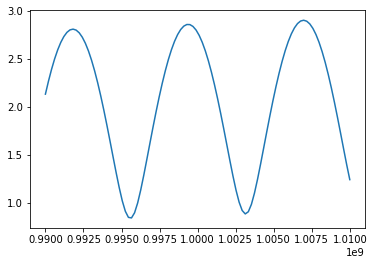

In [68]:
def impule_response_ground_and_wall(fc, d1, d2, ht, hr):
    r1_dist = np.sqrt(d1**2 + (ht-hr)**2)
    r2_dist = np.sqrt(d1**2 + (ht+hr)**2)
    r3_dist = np.sqrt((d1+2*d2)**2 + (ht-hr)**2)
    gain = np.ones(3)
    delay = np.array([r1_dist, r2_dist, r3_dist])/constants.speed_of_light
    phase = np.array([0, np.exp(-1j*np.pi), np.exp(-1j*np.pi)])
    return gain, delay, phase

freq = np.linspace(1e9-10e6,1e9+10e6,100)
h_gain, h_delay, h_phase = impule_response_ground_and_wall(1e9, 100, 20, 10, 4)

h = np.zeros(freq.size, dtype=np.complex128)
for i in np.arange(h_gain.size):
    h += h_gain[i] * np.exp(-1j*2*np.pi*(fc+freq)*h_delay[i]) * np.exp(-1j*h_phase[i])
    

plt.plot(freq,np.abs(h))


# 2.18

In [9]:
d0 = 1 # meters
d = np.array([5, 25, 65, 110, 400, 1000]) # meters
d_in_dB = 10*np.log10(d/d0).reshape(-1,1)
loss = np.array([-60, -80, -105, -115, -135, -150]) # dB

# Create linear regression object
linear_regression = linear_model.LinearRegression()
linear_regression.fit(d_in_dB, loss)
loss_pred = linear_regression.predict(d_in_dB)

# The coefficients
print('gamma: ', linear_regression.coef_[0])
print('K:     ', linear_regression.intercept_)

gamma:  -4.03937200289
K:      -29.7200336627


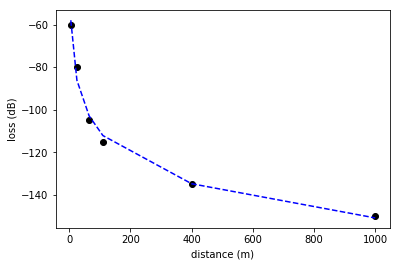

In [10]:
plt.plot(d, loss, 'ok')
plt.plot(d, loss_pred, '--b')
plt.ylabel('loss (dB)')
plt.xlabel('distance (m)')

In [18]:
np.array((loss-loss_pred)**2).mean()

9.2460391070342531

In [ ]:
print("Loss at 2000m: {:.0f} dB".format(
      linear_regression.predict([[10*np.log10(2000/d0)]])[0]))

# 2.23

In [12]:
gamma = 3
d0 = 1 # meters
K = 0 # dB
sigma = 4 # dB
R = 100 # meters
Pt = 10*np.log10(80) # dBm
Pmin = -100 # dBm

Pr = Pt + K - 10*gamma*np.log10(R/d0)
a = (Pmin - Pr)/sigma
b = 10*gamma*np.log10(np.exp(1))/sigma
print("Coverage area: {}".format(
    stats.norm.sf(a)+np.exp((2-2*a*b)/b**2)*stats.norm.sf((2-a*b)/b)))

Coverage area: 1.0


# 2.25